**LOAD DATA**

In [1]:
import pandas as pd

df = pd.read_csv('leads_recommender.csv', dtype=str)
df['text_features'] = (
    df['name'].fillna('') + ' ' +
    df['market'].fillna('') + ' ' +
    df['category_list'].fillna('')
)

# **CHOOSE INTENT KEYWORDS**

**COMMON WORDS**

In [2]:
from collections import Counter
import re

all_text = ' '.join(df['text_features'].dropna().astype(str)).lower()
words = re.findall(r'\b\w+\b', all_text)
word_counts = Counter(words)
print("Most common words:")
print(word_counts.most_common(50))

Most common words:
[('software', 5329), ('other', 2766), ('biotechnology', 2729), ('mobile', 1944), ('web', 1751), ('health', 1686), ('commerce', 1511), ('technology', 1447), ('e', 1416), ('media', 1399), ('social', 1238), ('enterprise', 1121), ('advertising', 1117), ('curated', 1112), ('and', 1031), ('care', 943), ('clean', 898), ('games', 853), ('analytics', 754), ('hardware', 746), ('finance', 720), ('education', 699), ('wellness', 633), ('security', 609), ('services', 494), ('marketing', 493), ('data', 490), ('manufacturing', 476), ('internet', 458), ('medical', 447), ('cloud', 418), ('saas', 407), ('video', 395), ('technologies', 367), ('hosting', 354), ('semiconductors', 347), ('consulting', 347), ('real', 342), ('search', 340), ('apps', 317), ('hospitality', 315), ('management', 313), ('big', 308), ('com', 306), ('computing', 290), ('estate', 288), ('fashion', 271), ('network', 267), ('news', 253), ('entertainment', 251)]


**COMMON BIGRAMS**

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2,2), max_features=50)
X = vectorizer.fit_transform(df['text_features'].fillna(''))
bigrams = vectorizer.get_feature_names_out()
bigram_counts = X.sum(axis=0).A1
bigram_freq = sorted(zip(bigrams, bigram_counts), key=lambda x: -x[1])
print("Most common bigrams:")
print(bigram_freq[:20])

Most common bigrams:
[('biotechnology biotechnology', np.int64(1277)), ('software software', np.int64(1182)), ('curated web', np.int64(1111)), ('enterprise software', np.int64(1093)), ('health care', np.int64(913)), ('clean technology', np.int64(855)), ('social media', np.int64(824)), ('hardware software', np.int64(685)), ('health and', np.int64(634)), ('and wellness', np.int64(625)), ('commerce commerce', np.int64(416)), ('care health', np.int64(405)), ('technology clean', np.int64(389)), ('mobile mobile', np.int64(387)), ('web hosting', np.int64(354)), ('software enterprise', np.int64(310)), ('software hardware', np.int64(292)), ('web curated', np.int64(289)), ('real estate', np.int64(287)), ('big data', np.int64(284))]


**INSTALL AND IMPORT LIBRARIES**

In [4]:
!pip install scikit-learn pandas numpy joblib

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import joblib

In [5]:
df.to_csv('leads_intent.csv', index=False)
print(df[['name', 'market', 'category_list', 'text_features']].head())

                name market  \
0            waywire   news   
1  tv-communications  games   
2    rock-your-paper  other   
3   in-touch-network  other   
4   r-ranch-and-mine  other   

                                       category_list  \
0         |entertainment|politics|social media|news|   
1                                            |games|   
2                             |publishing|education|   
3  |electronics|guides|coffee|restaurants|music|i...   
4                      |tourism|entertainment|games|   

                                       text_features  
0  waywire news |entertainment|politics|social me...  
1                    tv-communications games |games|  
2       rock-your-paper other |publishing|education|  
3  in-touch-network other |electronics|guides|cof...  
4  r-ranch-and-mine other |tourism|entertainment|...  


**INTENT KEYWORDS**

In [6]:
intent_keywords = [
    "software", "technology", "analytics", "consulting", "services", "cloud", "hosting",
    "marketing", "enterprise", "platform", "solution", "data", "saas", "media", "security"
]
intent_phrases = [
    "expanding to", "seeking investment", "raising capital", "new office", "launching", "hiring for"
]

def detect_intent(text):
    text = str(text).lower()
    keyword_count = sum(kw in text for kw in intent_keywords)
    phrase_present = any(phrase in text for phrase in intent_phrases)
    return int(keyword_count >= 2 or phrase_present)

df['intent'] = df['text_features'].apply(detect_intent)
print(df['intent'].value_counts())

intent
0    11940
1     2152
Name: count, dtype: int64


**DATA MODELLING**

In [7]:
X_text = df['text_features'].fillna('')
y = df['intent'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

**TF-IDF VECTORIZATION**

In [8]:
tfidf = TfidfVectorizer(max_features=200, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

**SMOTE ANALYSIS**

In [9]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_tfidf, y_train)
print("class distribution:", np.bincount(y_train_bal))

class distribution: [9551 9551]


**TRAIN LOGISTIC REGRESSION**

In [10]:
clf = LogisticRegression(max_iter=200, random_state=42, class_weight='balanced')
clf.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=200, random_state=42)

**MODEL EVALUATION**

Accuracy: 0.9460801702731465
ROC AUC: 0.9835320801736641
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2389
           1       0.77      0.92      0.84       430

    accuracy                           0.95      2819
   macro avg       0.88      0.94      0.90      2819
weighted avg       0.95      0.95      0.95      2819



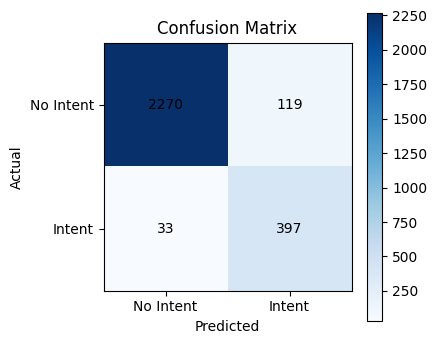

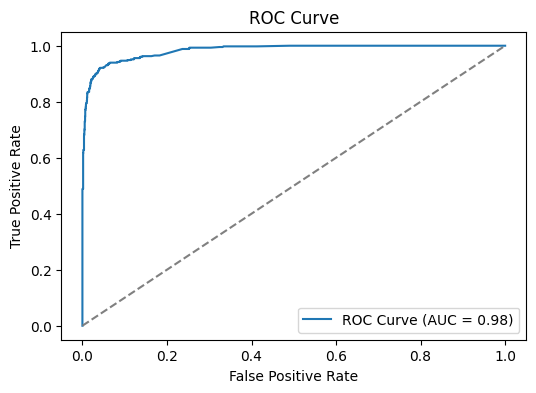

In [11]:
y_pred = clf.predict(X_test_tfidf)
y_pred_proba = clf.predict_proba(X_test_tfidf)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xticks([0,1], ['No Intent', 'Intent'])
plt.yticks([0,1], ['No Intent', 'Intent'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_proba)))
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**SAVE MODEL AND VECTORIZER**

In [12]:
joblib.dump(clf, 'intent_model.pkl')
joblib.dump(tfidf, 'intent_tfidf.pkl')

['intent_tfidf.pkl']

**SAMPLE INFERENCE**

In [13]:
example_text = "Our new cloud platform offers advanced analytics and security."
X_example = tfidf.transform([example_text])
intent_pred = clf.predict(X_example)[0]
intent_proba = clf.predict_proba(X_example)[0,1]
print(f"Text: {example_text}")
print(f"Intent Prediction: {'Intent' if intent_pred else 'No Intent'} (probability: {intent_proba:.2f})")

Text: Our new cloud platform offers advanced analytics and security.
Intent Prediction: Intent (probability: 0.98)
